We evaluate our methods on 4 mainstream object counting networks (i.e., MCNN, CSRNet, SANet, and ResNet-50).

In [2]:

import os
import random

def split_dataset_to_txt(root_dir, val_size=0.1):
    image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]
    # 打乱文件列表
    random.shuffle(image_files)
    
    # 计算划分点
    total_images = len(image_files)
    val_split_idx = int(total_images * (1-val_size))
    
    # 划分数据集
    train_files = image_files[:val_split_idx]
    val_files = image_files[val_split_idx:]
    
    write_dir = './train_data_split'
    os.makedirs(write_dir, exist_ok=True)
    # Save as a TXT file
    with open(os.path.join(write_dir, 'train.txt'), 'w') as f:
        f.write('\n'.join(train_files))
    with open(os.path.join(write_dir, 'val.txt'), 'w') as f:
        f.write('\n'.join(val_files))

random.seed(42)
split_dataset_to_txt('/Users/hannah/Downloads/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/images')

In [63]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.io import loadmat
from PIL import Image
from torchvision.transforms.functional import resize
from torchvision.transforms.functional import to_grayscale

class ShanghaiTechBDataset(Dataset):
    def __init__(self, root_dir, dataset_type='train', transform=None):
        """
        Args:
            image_dir (string): 图像文件的目录路径。
            gt_dir (string): 真值文件的目录路径。
            dataset_type ('train', 'val', 'test'): 指定数据划分集类型。
            transform (callable, optional): 可选的图像转换操作。
        """
        if dataset_type == 'train' or dataset_type == 'val':
            root_dir = os.path.join(root_dir, 'train_data')
            self.image_dir = os.path.join(root_dir, 'images')
            txt_file_path = os.path.join('./train_data_split', dataset_type+'.txt')
            with open(txt_file_path, 'r') as file:
                self.image_files = file.read().splitlines()
        else:
            root_dir = os.path.join(root_dir, dataset_type+'_data')
            self.image_dir = os.path.join(root_dir, 'images')
            self.image_files = [f for f in os.listdir(self.image_dir) if f.endswith('.jpg')]        
        
        self.gt_dir = os.path.join(root_dir, 'ground-truth')
        self.transform = transform

        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir, self.image_files[idx]))
        
        gt_name = os.path.join(self.gt_dir, 'GT_' + self.image_files[idx].replace('.jpg', '.mat'))
        gt_data = loadmat(gt_name)
        number = gt_data['image_info'][0][0][0][0][1][0][0]  # 获取人数

        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(number, dtype=torch.float)

In [64]:
import matplotlib.pyplot as plt

def show_batch_images(dataloader):
    """
    展示DataLoader中一个批次的图像和真值。
    
    Args:
        dataloader (DataLoader): PyTorch DataLoader对象。
    """
    # 获取一个批次的数据
    images, numbers = next(iter(dataloader))
    
    # 设置图像大小
    plt.figure(figsize=(6, 10))
    
    # 获取批次大小，以确定每行展示几张图
    batch_size = len(images)
    
    # 对批次中的每个图像进行遍历
    for idx in range(batch_size):
        ax = plt.subplot(1, len(images), idx+1)
        img = images[idx].numpy().transpose((1, 2, 0))
        plt.imshow(img)        
        # 在图像上方显示人数真值
        plt.title(f'Count: {numbers[idx].item()}')
        plt.axis('off')
    
    plt.show()

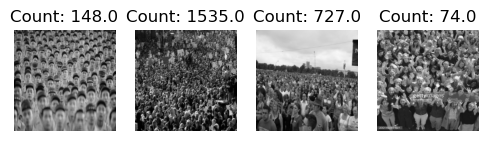

In [89]:


from torchvision.transforms import Resize, Grayscale, ToTensor, Compose

# Define the image transformation pipeline
transforms = Compose([
    Grayscale(num_output_channels=3),  # Convert to grayscale with 1 channel
    Resize((224, 224)),  # Resize the image
    ToTensor(),  # Convert the image to a PyTorch tensor
])


chk_shanghai_dataset = ShanghaiTechBDataset(root_dir='/Users/hannah/Downloads/ShanghaiTech_Crowd_Counting_Dataset/part_A_final',
                             dataset_type='train',
                             transform=transforms)

# 通过DataLoader加载数据
chk_data_loader = DataLoader(chk_shanghai_dataset, batch_size=4, shuffle=True)

# 测试DataLoader
show_batch_images(dataloader=chk_data_loader)

In [66]:

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


class AgePredictorAlex(nn.Module):
    def __init__(self):
        super(AgePredictorAlex, self).__init__()
        alexnet = models.alexnet(pretrained=True)
        # 使用AlexNet的特征提取部分
        self.features = alexnet.features
        
        # 替换AlexNet的分类器部分以适应年龄回归任务
        self.regressor = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),  # 根据AlexNet特征图的维度调整
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.regressor(x)
        return x

In [91]:


train_shanghai_dataset = ShanghaiTechBDataset(root_dir='/Users/hannah/Downloads/ShanghaiTech_Crowd_Counting_Dataset/part_A_final',
                             dataset_type='train',
                             transform=transforms)
train_data_loader = DataLoader(train_shanghai_dataset, batch_size=32, shuffle=True)

val_shanghai_dataset = ShanghaiTechBDataset(root_dir='/Users/hannah/Downloads/ShanghaiTech_Crowd_Counting_Dataset/part_A_final',
                             dataset_type='val',
                             transform=transforms)
val_data_loader = DataLoader(val_shanghai_dataset, batch_size=32, shuffle=True)

test_shanghai_dataset = ShanghaiTechBDataset(root_dir='/Users/hannah/Downloads/ShanghaiTech_Crowd_Counting_Dataset/part_A_final',
                             dataset_type='test',
                             transform=transforms)
test_data_loader = DataLoader(test_shanghai_dataset, batch_size=32, shuffle=True)

In [68]:
#pip install tensorboardX


In [94]:
from tensorboardX import SummaryWriter

writer = SummaryWriter('runs/age_prediction_experiment')

def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    for inputs, ages in train_loader:
        inputs, ages = inputs.to(device), ages.to(device)        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, ages.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)        
    writer.add_scalar('Loss/train', avg_loss, epoch)
    return avg_loss

def validate(model, val_loader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, ages in val_loader:
            inputs, ages = inputs.to(device), ages.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, ages.view(-1, 1))
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    # writer.add_scalar('Loss/val', avg_loss, epoch)
    return avg_loss

In [61]:
device = torch.device("cpu")
print(device)
model = AgePredictorAlex().to(device)
print('model instantiation done')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

cpu
model instantiation done


In [95]:

%%time

num_epochs = 50
for epoch in range(num_epochs):
    # print('epoch begin')
    train_loss = train(model, train_data_loader, criterion, optimizer, device, epoch)
    val_loss = validate(model, val_data_loader, criterion, device, epoch)
    
    best_val_loss = float('inf')
    # 检查是否为最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')  # 保存最佳模型的参数
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

Epoch 1, Train Loss: 285012.4279513889, Val Loss: 226328.390625
Epoch 2, Train Loss: 290708.97222222225, Val Loss: 288125.53125
Epoch 3, Train Loss: 250340.02690972222, Val Loss: 259745.078125
Epoch 4, Train Loss: 220746.31944444444, Val Loss: 193953.265625
Epoch 5, Train Loss: 202057.78298611112, Val Loss: 191165.28125
Epoch 6, Train Loss: 219870.26866319444, Val Loss: 286236.28125
Epoch 7, Train Loss: 198321.67317708334, Val Loss: 179426.78125
Epoch 8, Train Loss: 168138.64496527778, Val Loss: 195266.28125
Epoch 9, Train Loss: 145183.0390625, Val Loss: 134424.984375
Epoch 10, Train Loss: 120123.54383680556, Val Loss: 150667.0625
Epoch 11, Train Loss: 100993.96050347222, Val Loss: 162022.25
Epoch 12, Train Loss: 125300.66362847222, Val Loss: 173696.984375
Epoch 13, Train Loss: 122022.13107638889, Val Loss: 300747.5625
Epoch 14, Train Loss: 116552.34765625, Val Loss: 144341.34375
Epoch 15, Train Loss: 106007.20399305556, Val Loss: 185298.734375
Epoch 16, Train Loss: 100330.38411458333,

In [96]:
#pip show torch


Name: torch
Version: 2.2.2
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /Users/hannah/anaconda3/lib/python3.10/site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: torchaudio, torchvision
Note: you may need to restart the kernel to use updated packages.


In [95]:
pip install --upgrade torch torchvision torchaudio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.2 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [96]:
import math

def test(model, test_loader, device):
    sum_squared_error = 0.0
    sum_absolute_error = 0.0
    total_samples = 0
    
    model.eval()
    model.load_state_dict(torch.load('best_model.pth'))
    with torch.no_grad():
        for images, ages in test_loader:
            images, ages = images.to(device), ages.to(device)

            outputs = model(images)
            # 计算RMSE的累加值
            squared_errors = (outputs.view(-1) - ages) ** 2
            sum_squared_error += squared_errors.sum().item()

            # 计算MAE的累加值
            absolute_errors = torch.abs(outputs.view(-1) - ages)
            sum_absolute_error += absolute_errors.sum().item()

            # 累加样本总数
            total_samples += ages.size(0)

    # 计算最终的RMSE和MAE
    rmse = math.sqrt(sum_squared_error / total_samples)
    mae = sum_absolute_error / total_samples

    print(f'Test RMSE: {rmse:.4f}')
    print(f'Test MAE: {mae:.4f}')

In [97]:
def visualize_predictions(model, data_loader, device, num_images=5):
    model.eval()
    images, ages = next(iter(data_loader))
    images, ages = images.to(device), ages.to(device)
    with torch.no_grad():
        outputs = model(images)
    predictions = outputs.view(-1).cpu().numpy()
    actuals = ages.cpu().numpy()

    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        plt.imshow(img)
        plt.title(f'Actual: {actuals[i]:.2f}\nPredicted: {predictions[i]:.2f}', color='black')
        plt.axis('off')
    plt.show()

Test RMSE: 239.2708
Test MAE: 153.3436


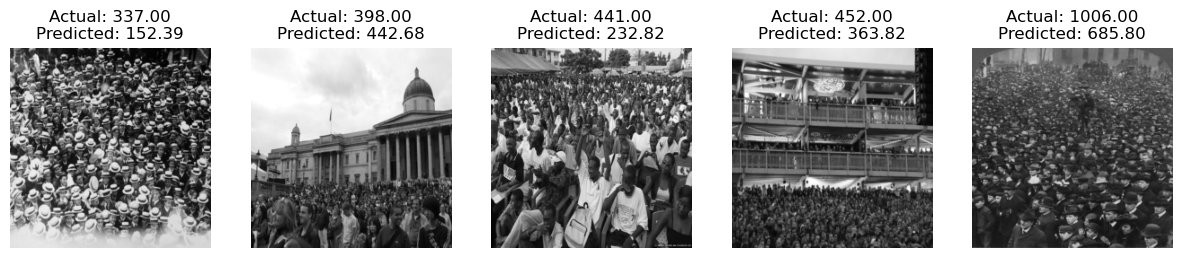

In [99]:
test(model, test_data_loader, device)
visualize_predictions(model, test_data_loader, device)